In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, Callback

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
train_dir = '/kaggle/input/weed-detection-in-crop-fields/data/train'
test_dir = '/kaggle/input/weed-detection-in-crop-fields/data/test'

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-5

In [3]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 833 images belonging to 2 classes.
Found 207 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [4]:
# Feature Extraction with MobileNetV2
# base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Feature Extraction with VGG16
# base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
# Feature Extraction with ResNet50
# base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Feature Extraction with InceptionV3
# base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
# Feature Extraction with EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    features, labels = [], []
    for inputs, targets in generator:
        features.append(feature_extractor.predict(inputs))
        labels.append(targets)
        if len(features) >= len(generator):
            break
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(val_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)

train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

I0000 00:00:1733483891.129425   13274 service.cc:145] XLA service 0x79f728145e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733483891.129470   13274 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733483891.129474   13274 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1733483897.116017   13274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━

In [10]:
# Custom callback to log learning rate and loss
class LearningRateLossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lrs.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs.get('loss'))

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    return lr * 0.95  # Reduce learning rate by 5% each epoch

lr_logger = LearningRateLossLogger()
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

In [11]:
# custom callback for Precision, Recall, and F1-Score vs Epochs
class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.precisions = []
        self.recalls = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = (self.model.predict(val_generator) > 0.5).astype(int).flatten()
        val_labels = val_generator.classes

        precision = precision_score(val_labels, val_predictions)
        recall = recall_score(val_labels, val_predictions)
        f1 = f1_score(val_labels, val_predictions)

        self.precisions.append(precision)
        self.recalls.append(recall)
        self.f1_scores.append(f1)

# Train model with the custom metrics logger
metrics_logger = MetricsLogger()

In [12]:
# Build and Fine-Tune End-to-End Classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Initial training
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Fine-tune
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_logger, metrics_logger, lr_scheduler_callback]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4977 - loss: 0.6957 - val_accuracy: 0.4879 - val_loss: 0.6948
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4920 - loss: 0.6958 - val_accuracy: 0.4879 - val_loss: 0.6943
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.4956 - loss: 0.6954 - val_accuracy: 0.4879 - val_loss: 0.6958
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.4640 - loss: 0.7007 - val_accuracy: 0.4879 - val_loss: 0.6968
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4817 - loss: 0.6979 - val_accuracy: 0.4879 - val_loss: 0.6946
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4877 - loss: 0.6948 - val_accuracy: 0.5121 - val_loss: 0.6928
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4558 - loss: 0.6967 - val_accuracy: 0.4879 - val_loss: 0.6932
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.4659 - loss: 0.6940 - val_accuracy: 0.5121 - val_lo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step ep - accuracy: 0.6306 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.6319 - loss: 0.6310 - val_accuracy: 0.4879 - val_loss: 0.6985 - learning_rate: 8.5737e-06
Epoch 4/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step ep - accuracy: 0.7188 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7195 - loss: 0.5442 - val_accuracy: 0.4879 - val_loss: 2.6761 - learning_rate: 8.1451e-06
Epoch 5/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/stepep - accuracy: 0.7933 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.7937 - loss: 0.4608 - val_accuracy: 0.4879 - val_loss: 9.7870 - learning_rate: 7.7378e-06
Epoch 6/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/stepep - accuracy: 0.8159 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8162 - loss: 0.4225 - val_accuracy: 0.4928 - val_loss: 16.8297 - learning_rate: 7.3509e-06
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step ep - accuracy: 0.8400 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8404 - loss: 0.4132 - val_accuracy: 0.4928 - val_loss: 32.3262 - learning_rate: 6.9834e-06
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/stepep - accuracy: 0.8602 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.8604 - loss: 0.3682 - val_accuracy: 0.4879 - val_loss: 75.4417 - learning_rate: 6.6342e-06
Epoch 9/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step ep - accuracy: 0.8859 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.8860 - loss: 0.3519 - val_accuracy: 0.4879 - val_loss: 86.9290 - learning_rate: 6.3025e-06
Epoch 10/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/stepep - accuracy: 0.9117 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9112 - loss: 0.3231 - val_accuracy: 0.4879 - val_loss: 82.5728 - learning_rate: 5.9874e-06
Epoch 11/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step ep - accuracy: 0.9145 - lo
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9150 - loss: 0.3200 - val_accuracy: 0.4879 - val_loss: 84.3908 - learning_rate: 5.6880e-06
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step ep - accuracy: 0.9199 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9200 - loss: 0.2864 - val_accuracy: 0.4638 - val_loss: 69.7379 - learning_rate: 5.4036e-06
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step ep - accuracy: 0.9313 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9313 - loss: 0.3098 - val_accuracy: 0.4879 - val_loss: 75.6770 - learning_rate: 5.1334e-06
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/stepep - accuracy: 0.9106 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9112 - loss: 0.2889 - val_accuracy: 0.5121 - val_loss: 64.2682 - learning_rate: 4.8767e-06
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/stepep - accuracy: 0.9391 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0

In [13]:
# Classifiers
classifiers = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, clf in classifiers.items():
    clf.fit(train_features_flat, train_labels)

In [14]:
def evaluate(clf, X, y_true, is_keras_model=False):
    if is_keras_model:
        y_pred = (clf.predict(X) > 0.5).astype(int).flatten()
        y_proba = clf.predict(X).flatten()
    else:
        y_pred = clf.predict(X)
        y_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, "predict_proba") else None

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    return accuracy, precision, recall, f1, auc


In [15]:

# Evaluate classifiers
true_labels = test_generator.classes
for name, clf in classifiers.items():
    print(f"\n{name} Performance:")
    metrics = evaluate(clf, test_features_flat, true_labels)
    print(f"Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, "
          f"F1: {metrics[3]:.4f}, AUC: {metrics[4]:.4f}")

# Evaluate Model
metrics = evaluate(model, test_generator, true_labels, is_keras_model=True)
print("\nModel Performance:")
print(f"Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, "
      f"F1: {metrics[3]:.4f}, AUC: {metrics[4]:.4f}")


SVM Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       127
           1       0.51      1.00      0.68       133

    accuracy                           0.51       260
   macro avg       0.26      0.50      0.34       260
weighted avg       0.26      0.51      0.35       260

Accuracy: 0.5115, Precision: 0.5115, Recall: 1.0000, F1: 0.6768, AUC: 0.3385

Logistic Regression Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       127
           1       0.61      0.69      0.65       133

    accuracy                           0.62       260
   macro avg       0.62      0.61      0.61       260
weighted avg       0.62      0.62      0.61       260

Accuracy: 0.6154, Precision: 0.6093, Recall: 0.6917, F1: 0.6479, AUC: 0.6836

Random Forest Performance:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       127
           1       0.87      0.92      0.89       133

    accuracy                           0.88       260
   macro avg       0.89      0.88      0.88       260
weighted avg       0.89      0.88      0.88       260

Accuracy: 0.8846, Precision: 0.8652, Recall: 0.9173, F1: 0.8905, AUC: 0.9402

Decision Tree Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       127
           1       0.83      0.87      0.85       133

    accuracy                           0.84       260
   macro avg       0.84      0.84      0.84       260
weighted avg       0.84      0.84      0.84       260

Accuracy: 0.8423, Precision: 0.8286, Recall: 0.8722, F1: 0.8498, AUC: 0.8416
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       127
           1       0.97      0.98      0.98       133

    accuracy                           0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.98      0.98      0.98       260


Model Performance:
Accuracy: 0.9769, Precision: 0.9704, Recall: 0.9850, F1: 0.9776, AUC: 0.9901


In [16]:
# Visualization

# Plot Training vs Validation Accuracy and Loss
def plot_training(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# ROC Curve
def plot_auc_roc(y_true, y_proba, title="AUC-ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=test_generator.class_indices.keys(), 
                yticklabels=test_generator.class_indices.keys())
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall(y_true, y_proba, title="Precision vs Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}', color='purple')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Learning Rate vs Loss
def plot_LR(title="Learning Rate vs Loss"):
    plt.figure(figsize=(8, 6))
    plt.plot(lr_logger.lrs, lr_logger.losses, marker='o', color='purple')
    plt.title(title)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.xscale('log')
    plt.grid()
    plt.show()

# Plot Precision, Recall, and F1-Score vs Epochs
def plot_metrices_epochs(title="Precision, Recall, and F1-Score vs Epochs"):
    plt.figure(figsize=(8, 6))
    epochs_range = range(1, EPOCHS + 1)
    plt.plot(epochs_range, metrics_logger.precisions, label='Precision', color='blue')
    plt.plot(epochs_range, metrics_logger.recalls, label='Recall', color='green')
    plt.plot(epochs_range, metrics_logger.f1_scores, label='F1-Score', color='red')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()

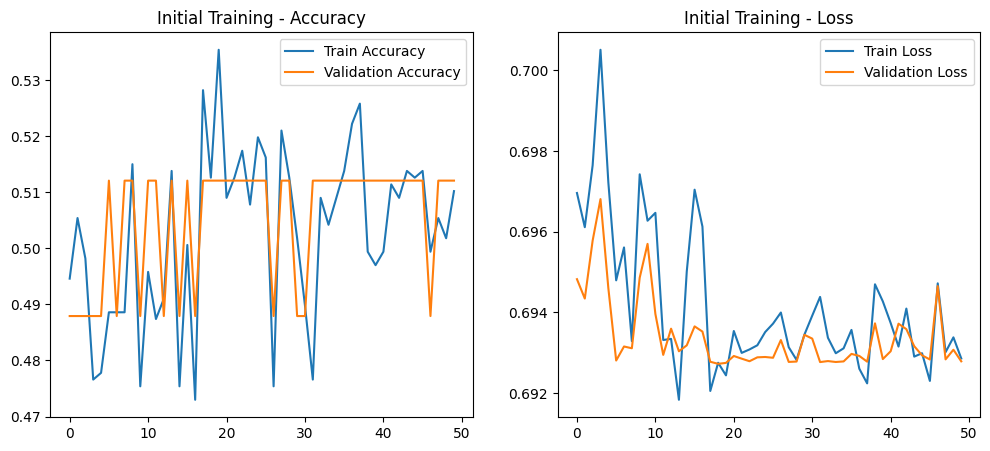

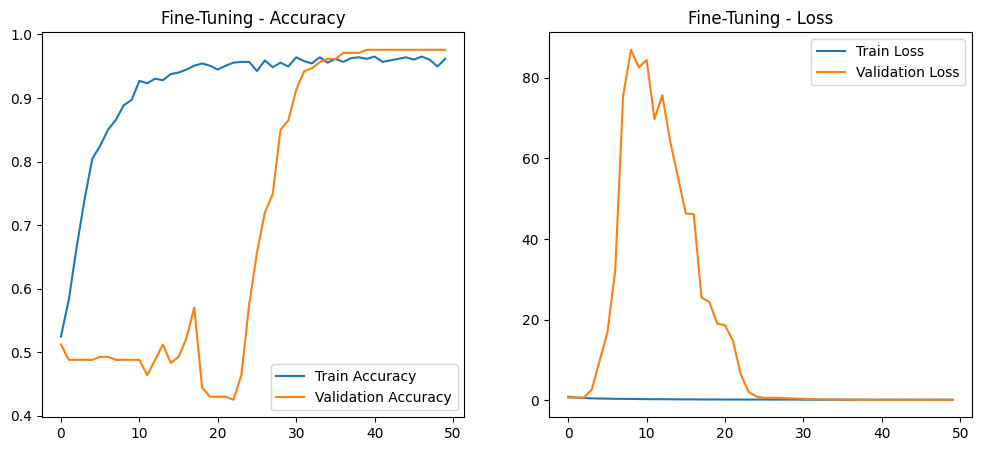

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 


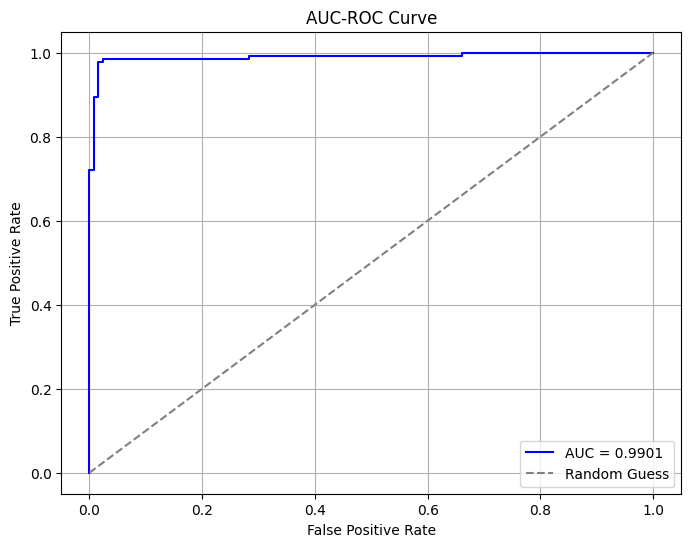

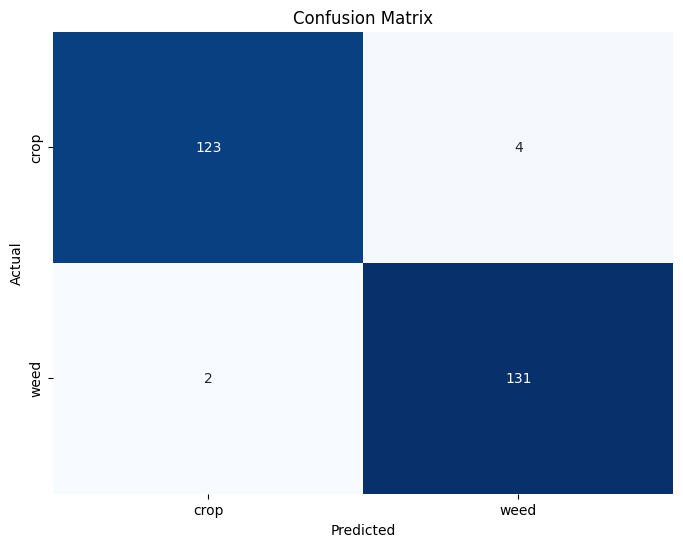

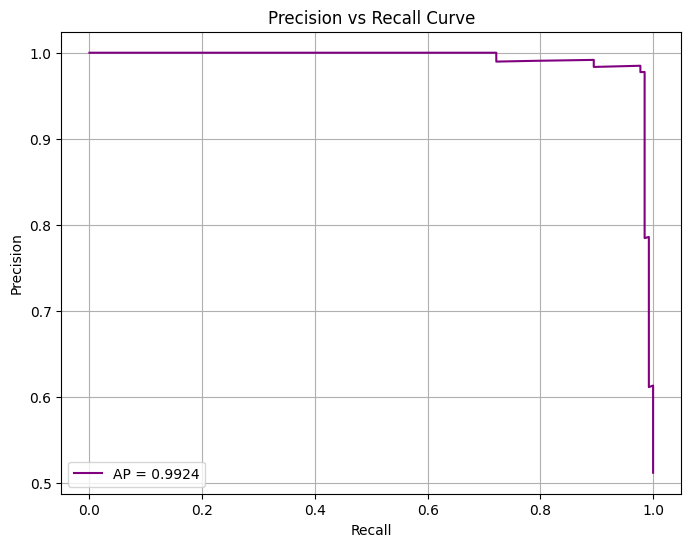

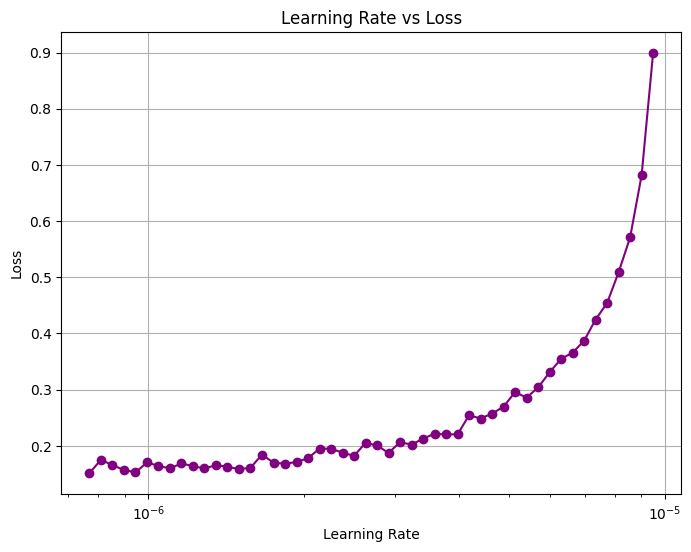

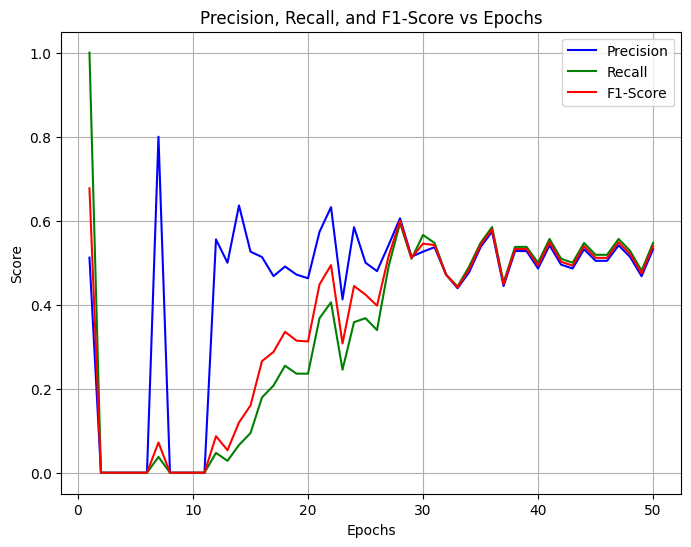

In [17]:
# Training vs Validation Accuracy and Loss
plot_training(history, "Initial Training")
plot_training(fine_history, "Fine-Tuning")

# Generate and visualize results
y_proba = model.predict(test_generator).flatten()
y_pred = (y_proba > 0.5).astype(int)

# ROC Curve and AUC
plot_auc_roc(true_labels, y_proba)

# Confusion Matrix
plot_confusion_matrix(true_labels, y_pred)

# Precision-Recall Curve
plot_precision_recall(true_labels, y_proba)

# Learning Rate vs Loss
plot_LR()

# Precision, Recall, and F1-Score vs Epochs
plot_metrices_epochs()